## Summary
This report describes my implementation of a convolutional neural network (CNN) to predict steering angles from a set of training images acquired from a driving simulator. The CNN is a slightly modified Keras implementation of this paper from NVIDIA Corporation. The trained model successfully steered the simulated car around track-1 of the beta-simulator provided as part of this project.

This report describes results from training performed using the sample dataset provided by Udacity and my own training set from tracks 1 and 2 which I acquired by manually driving the car.

# Project 4 - Behavioral Cloning
### Lukasz Uszko, June 2019

## Submission
The following files accompany this report:

* `model.py`: Script used to create and train the CNN. This report describes how the model was developed and trained.
* `model.h5`: The trained model, created by the above script.
* `drive.py`: Script used to drive the car using the trained model above.
## Usage
* Open a terminal and start the simulator: ./beta_simulator.x86_64
* Open another terminal and run the following to drive the simulated car autonomously: python drive.py model.h5
* The simulated car will now start moving. Verify that the car stays on the road at all times

## Imports and project globals

In [36]:
# Imports
import pickle
import math
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import skimage
import csv
import scipy
import copy
import pickle

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from random import shuffle
from tqdm import tqdm

# Visualizations will be shown in the notebook.
%matplotlib inline

# Some globals
DATA_FOLDER_PATH = './data'
STEERING_COEFFICIENT = 0.2
A4_PORTRAIT = (8.27, 11.69)
A4_LANDSCAPE = A4_PORTRAIT[::-1]

## Model Development
### Loading the training set
I first examined the organisation of training data which consisted of a csv file and a set of images. The following code loads and prints out some basic information about training set.

In [37]:
# Read driving_log data
csv_file_path = os.path.join(DATA_FOLDER_PATH,'driving_log.csv')

samples = []
with open(csv_file_path) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
# Remove the header anymore
samples.pop(0);

### Data set visualisation
As you can see below on the steering angles distribtion histogram, the trainig data set skewed towards small steering angles.

In [38]:
# Show the head of csv file
csvfile = pd.read_csv(csv_file_path)
csvfile.head()

center  \
0  IMG/center_2016_12_01_13_30_48_287.jpg   
1  IMG/center_2016_12_01_13_30_48_404.jpg   
2  IMG/center_2016_12_01_13_31_12_937.jpg   
3  IMG/center_2016_12_01_13_31_13_037.jpg   
4  IMG/center_2016_12_01_13_31_13_177.jpg   

                                    left  \
0   IMG/left_2016_12_01_13_30_48_287.jpg   
1   IMG/left_2016_12_01_13_30_48_404.jpg   
2   IMG/left_2016_12_01_13_31_12_937.jpg   
3   IMG/left_2016_12_01_13_31_13_037.jpg   
4   IMG/left_2016_12_01_13_31_13_177.jpg   

                                    right  steering  throttle  brake  \
0   IMG/right_2016_12_01_13_30_48_287.jpg       0.0       0.0    0.0   
1   IMG/right_2016_12_01_13_30_48_404.jpg       0.0       0.0    0.0   
2   IMG/right_2016_12_01_13_31_12_937.jpg       0.0       0.0    0.0   
3   IMG/right_2016_12_01_13_31_13_037.jpg       0.0       0.0    0.0   
4   IMG/right_2016_12_01_13_31_13_177.jpg       0.0       0.0    0.0   

       speed  
0  22.148290  
1  21.879630  
2   1.453011  
3   1.438419  
4   1.418236

Steering angle range: ( -1.0 , 1.0 )


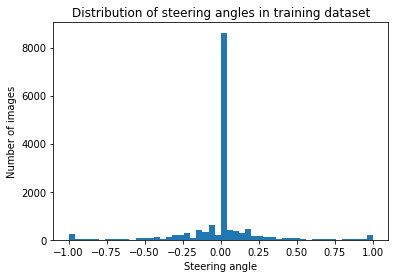

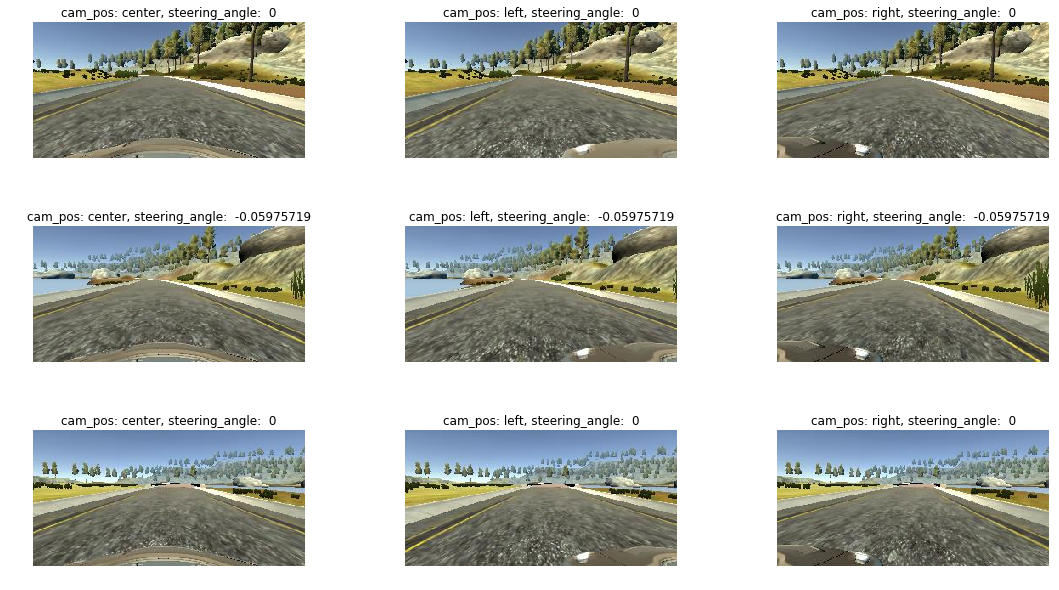

In [48]:
def load_image(filename):
    image = cv2.imread(filename)
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


def plot_images(images, titles, rows=3, cols=3, figsize=(20,10), gray=False, save_name='default'):
    images_to_show = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axes = axes.ravel()
    for i in range(images_to_show):
        image = images[i]
        axes[i].axis('off')
        axes[i].imshow(image)
        axes[i].set_title(titles[i])
    fig.savefig('examples/{}.png'.format(save_name))


def plot_steering_distribution(dataset, title):
    steering = [np.float32(x[3]) for x in dataset]
    print('Steering angle range: (', min(steering), ',', max(steering), ')')
    plt.figure()
    plt.hist(steering, bins=50)
    plt.xlabel('Steering angle')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()
    plt.savefig('examples/Distribution_of_steering_angles_in_training_dataset.png')

    
# Show Steering angle distribution
plot_steering_distribution(samples, 'Distribution of steering angles in training dataset')

# Print some sample dataset images
camera_positions = ['center', 'left', 'right']
rows = 3
sample_images = []
sample_images_titles = []
for r in range(rows):
    for cam_pos in range(len(camera_positions)):
        sample_images.append(load_image(os.path.join(DATA_FOLDER_PATH, samples[r][cam_pos].strip())))       
        sample_images_titles.append("cam_pos: {}, steering_angle: {}".format(camera_positions[cam_pos], samples[r][3]))
plot_images(sample_images, sample_images_titles, rows=rows, cols=len(camera_positions), figsize=(20,10), save_name='Sample_dataset_images')

### Data set preprocessing
For Image preprocessing I applied the follwing fucntions:
* Crop image - crops the image, on top it's 40% to remove sky, trees etc, and bottom by 20% to remove the car hood
* Resize image - All images are resized to 64x64 pixels

In [41]:
def crop_image(image, top_percent=0.4, bottom_percent=0.2):    
    assert 0 <= top_percent < 0.5, 'top_percent should be between 0.0 and 0.5'
    assert 0 <= bottom_percent < 0.5, 'top_percent should be between 0.0 and 0.5'

    top = int(np.ceil(image.shape[0] * top_percent))
    bottom = image.shape[0] - int(np.ceil(image.shape[0] * bottom_percent))
    return image[top:bottom, :]


def resize_image(image, new_dim=(64, 64)):
    return cv2.resize(image, new_dim)

### Visualize data preprocessing

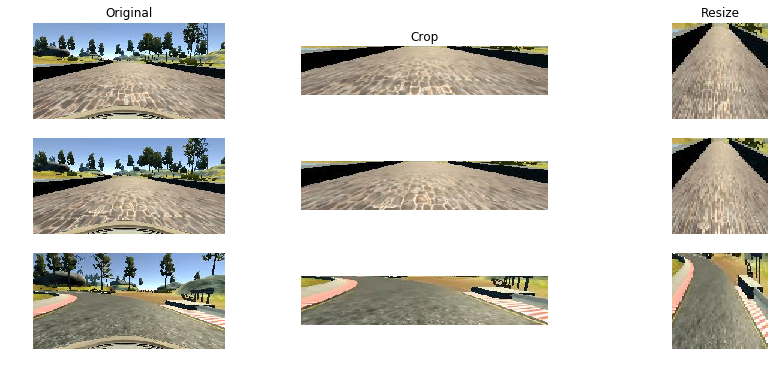

In [42]:
#===============================================================================================
def preprocess_image(img, top_crop_percent=0.35, bottom_crop_percent=0.15,
                       resize_dim=(64, 64)):
    # Cropping and normalization will be done in cropping and lambda steps in network layer
    # img = crop_image(img, top_crop_percent, bottom_crop_percent)
    # img = resize_image(img, resize_dim)
    return img

def display_preprocessed_data(images, save_name='default') :
    """
    Displays preprocessing pipeline for list of images
    """
    nrows = len(images)
    fig, axes = plt.subplots(nrows, 3, figsize=(15,2*nrows))
    
    # pre-processing pipeline
    preprocess_steps = ['Original','Crop','Resize']
    
    # plot pipeline
    for ax, p in zip(axes[0,:], preprocess_steps) :
        ax.set_title(p)
    for ax,img in zip(axes,images) :
        ax[0].imshow(img)
        img = crop_image(img)
        ax[1].imshow(img)
        img = resize_image(img)
        ax[2].imshow(img)
        for a in ax :
            a.axis('off')
    fig.savefig('examples/{}.png'.format(save_name))

rows = 3
preprocessed_images = []
for r in range(rows):
    preprocessed_images.append(load_image(os.path.join(DATA_FOLDER_PATH, samples[r][0].strip())))        
display_preprocessed_data(preprocessed_images, save_name='preprocessed_images')

### Data set augmentation

During training, you want to feed the left and right camera images to your model as if they were coming from the center camera. This way, you can teach your model how to steer if the car drifts off to the left or the right.

During prediction (i.e. "autonomous mode"), you only need to predict with the center camera image.
For Data augmentation I applied the follwing functions:
* Flip image - images are flipped by vertical axis and the sign of steering angle is changed
* Rotate image - Randomly rotated images

In [43]:
#===============================================================================================
def flip_image(image, steering_angle):
    return np.fliplr(image), -1 * steering_angle

def change_brightness(image):
    val = 0.3 + np.random.random()
    return image * val

In [44]:
#===============================================================================================
def augment_image(img, steering_angle):
    img, steering_angle = flip_image(img, steering_angle)
    #img = change_brightness(img)
    return img, steering_angle

# Create data (preprocess, augment)
def create_data(samples, steering_correction):
    images = []
    steering_angles = []
    img_types = ['center', 'left', 'right']
    for sample in samples:
        for i, type_img in enumerate(img_types):
            img = load_image(os.path.join(DATA_FOLDER_PATH, sample[i].strip()))
            # preprocess image
            img = preprocess_image(img)
            angle = float(sample[3])
            if 'center' in sample[i]:
                angle = angle
            elif 'left' in sample[i]:
                angle = angle+steering_correction
            else: #right
                angle = angle-steering_correction
            # Add images to the list
            images.append(img)
            steering_angles.append(angle)
            
            # create augmented image
            img = copy.deepcopy(images[-1])
            steering_angle = steering_angles[-1]
            img, angle = augment_image(img, steering_angle)
            # Load augmented data
            images.append(img)
            steering_angles.append(angle)
            
    return images, steering_angles


#===============================================================================================
# Image generator
def generate_batch(samples, batch_size=32):
    """
    Generator function to avoid loading all images and angles into memory
    """
    num_samples = len(samples)
    while True:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            steering_angles = []
            images, steering_angles = create_data(batch_samples, STEERING_COEFFICIENT)
            X_train = np.array(images)
            y_train = np.array(steering_angles)
            yield (X_train, y_train)

Batch: 0 , num images:  48 , num angles: 48
Batch: 1 , num images:  48 , num angles: 48
Images shape:  HEIGHT: 160 WIDTH: 320 CHANNELS: 3


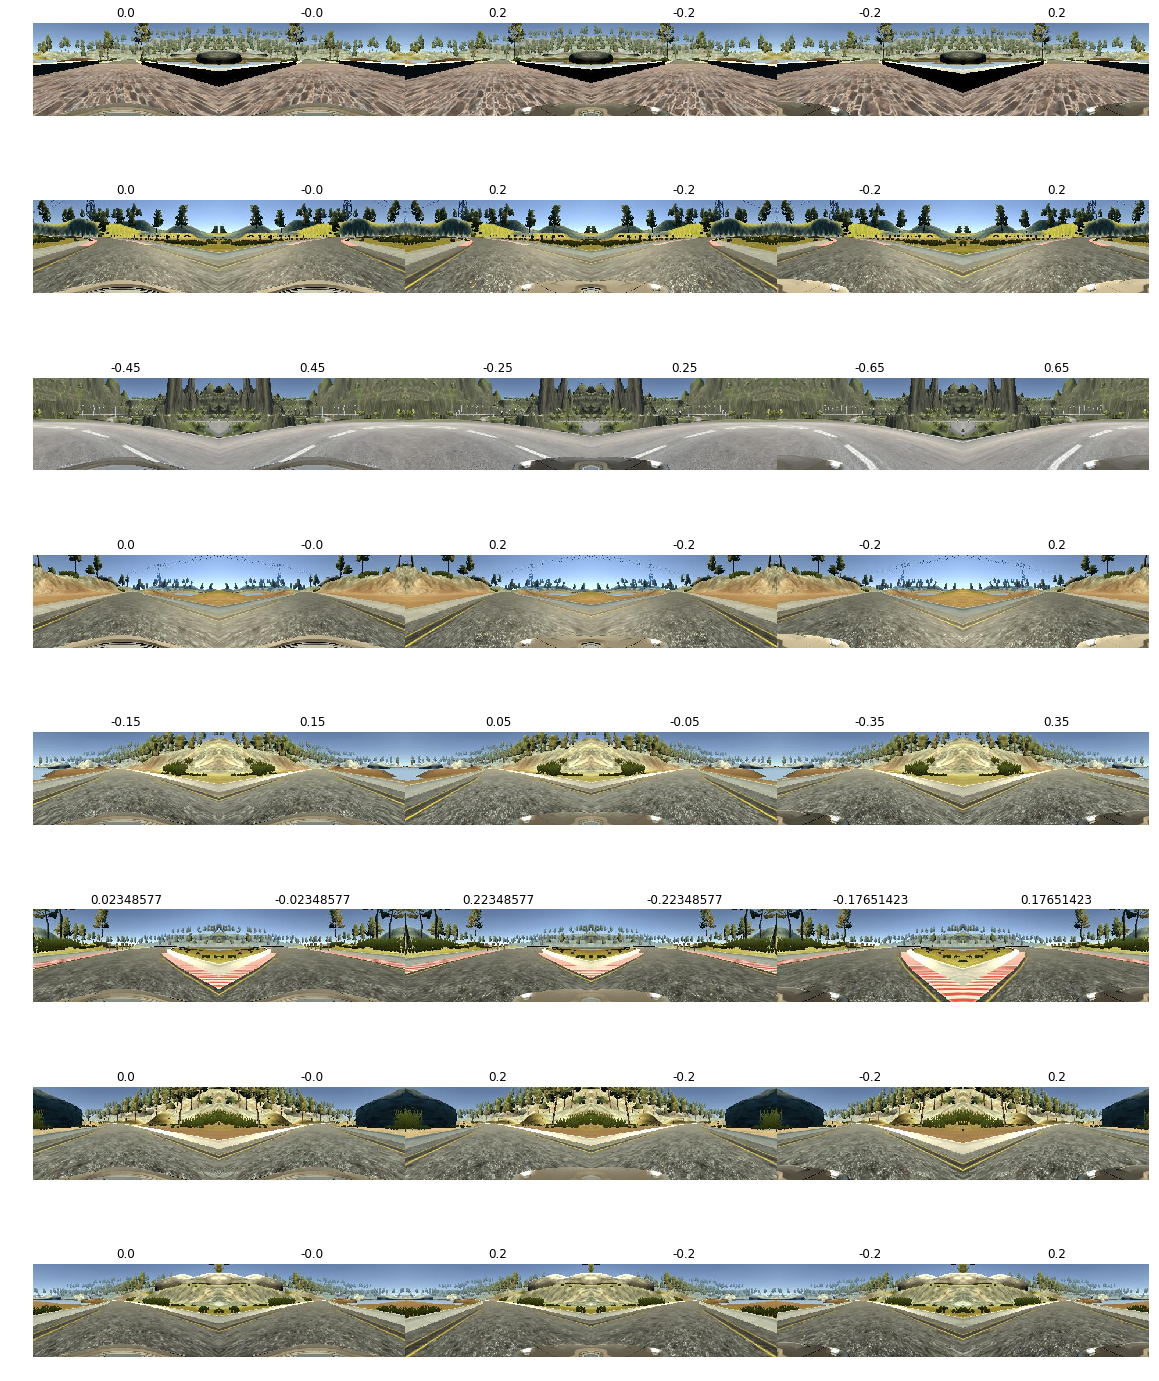

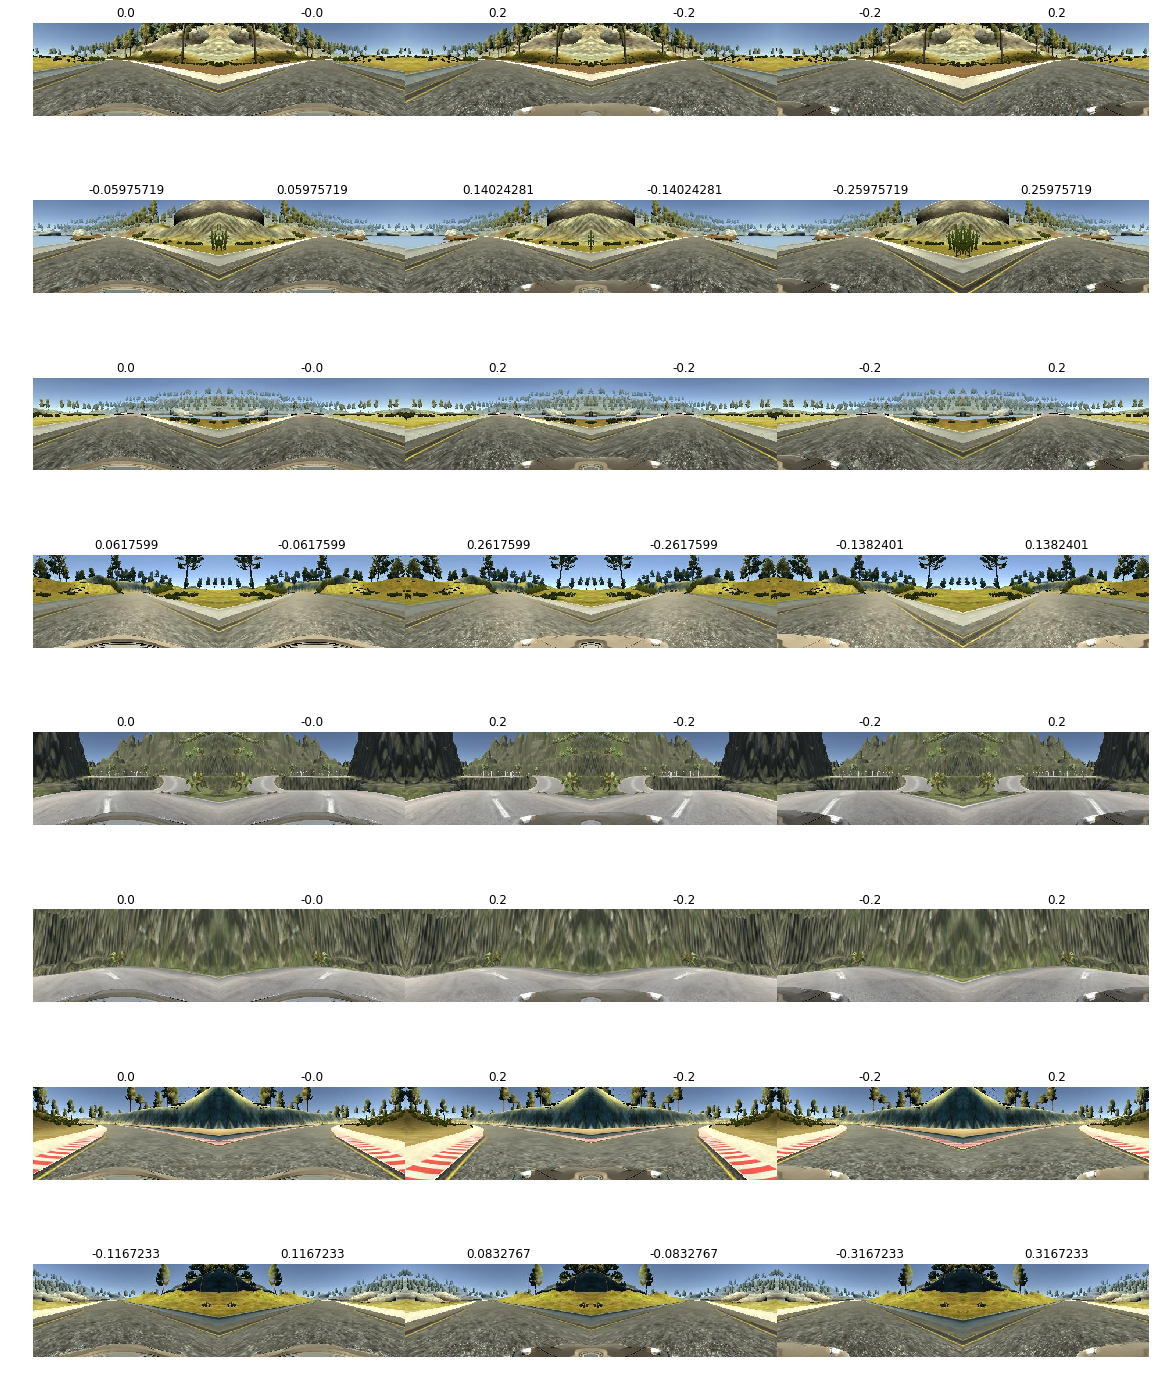

In [46]:
#===============================================================================================
# Test the generator
test_num = 2
batch_size=8
for i in range(test_num):
    images, angles = next(generate_batch(samples, batch_size=batch_size))
    print('Batch:', i,', num images: ', len(images), ', num angles:', len(angles))
    plot_images(images, angles, rows=8, cols=6, figsize=(20,25), save_name='generated_data')
    
# Set image sizes
img_height, img_width, img_channels = images[0].shape
print('Images shape: ', 'HEIGHT: {}'.format(img_height), 'WIDTH: {}'.format(img_width), 'CHANNELS: {}'.format(img_channels)) 

In [25]:
#===============================================================================================
# Split data into training and validation datasets
shuffle(samples)
training_samples, validation_samples = train_test_split(samples, test_size=0.2) 
print("Number of training samples: {}".format(len(training_samples)))
print("Number of validation samples: {}".format(len(validation_samples)))


Number of training samples: 11740
Number of validation samples: 2935


### Network Architecture

In [27]:
#===============================================================================================
# Define network
# We implement CNN architecture from the nvidia paper with a few modifications 
# (added elu activations, max-pooling and drop-outs)

from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

# generate the neural network
model = Sequential()


# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(img_height, img_width, img_channels)))

# Crop image to see only a road
model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=(img_height, img_width, img_channels)))

# Layer 1 - Convolution, no of filters- 24, filter size= 5x5, stride= 2x2
model.add(Convolution2D(24, (5,5), strides=(2,2)))
model.add(Activation('elu'))

# Layer 2 - Convolution, no of filters- 36, filter size= 5x5, stride= 2x2
model.add(Convolution2D(36, (5,5), strides=(2,2)))
model.add(Activation('elu'))

# Layer 3 - Convolution, no of filters- 48, filter size= 5x5, stride= 2x2
model.add(Convolution2D(48,(5,5), strides=(2,2)))
model.add(Activation('elu'))

# Layer 4 - Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Convolution2D(64, (3,3)))
model.add(Activation('elu'))

# Layer 5 - Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Convolution2D(64, (3,3)))
model.add(Activation('elu'))

# Flatten image from 2D to side by side
model.add(Flatten())

# Layer 6 - Fully connected layer 1
model.add(Dense(100))
model.add(Activation('elu'))

# Adding a dropout layer to avoid overfitting.
model.add(Dropout(0.25))

# Layer 7 - fully connected layer 1
model.add(Dense(50))
model.add(Activation('elu'))

# Layer 8 - fully connected layer 1
model.add(Dense(10))
model.add(Activation('elu'))

# Layer 9 - fully connected layer 1
model.add(Dense(1)) #here the final layer will contain one value as this is a regression problem and not classification

# Print a summary of the NN
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_3 (Cropping2D)    (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 38, 158, 24)       1824      
_________________________________________________________________
activation_17 (Activation)   (None, 38, 158, 24)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 17, 77, 36)        21636     
_________________________________________________________________
activation_18 (Activation)   (None, 17, 77, 36)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 37, 48)         43248     
__________

In [ ]:
#===============================================================================================
# checkpoint
checkpoint = ModelCheckpoint("model-{epoch:02d}.h5", monitor='loss', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

#===============================================================================================
# Compile and train the model using the generator function
EPOCHS = 5
BATCH_SIZE = 32

train_generator = generate_batch(training_samples, batch_size=BATCH_SIZE)
valid_generator = generate_batch(validation_samples, batch_size=BATCH_SIZE)

model.compile(loss='mse', optimizer='adam')

# Restore saved models paths
saved_models_paths = glob.glob('model-*.h5')
print(saved_models_paths)
if len(saved_models_paths) > 0:
    print("Restoring latest checkpoint: {} for training".format(saved_models_paths[-1]))
    model = load_model(saved_models_paths[-1])

history = model.fit_generator(train_generator, samples_per_epoch=len(training_samples), 
                    validation_data=valid_generator, nb_val_samples=len(validation_samples), 
                    nb_epoch=EPOCHS)

#===============================================================================================
# Save the model and weights
from keras.models import load_model
model.save("./model.h5")
print("Saved model to disk")

# Save the history
hist_history = history.history
pickle.dump(hist_history, open("hist_history.p", "wb"))

dict_keys(['val_loss', 'loss'])


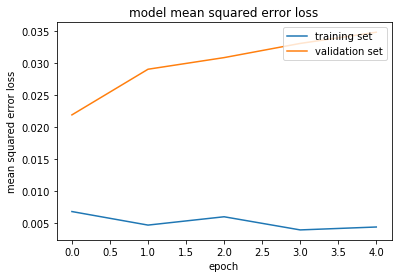

In [35]:
#===============================================================================================
# Load training history
history = pickle.load(open("hist_history.p", "rb"))
# Print some training stats
print(history.keys())

# plot the training and validation loss for each epoch
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()